**Initial step:** Please try to put the extracted heavy_makeup_CelebA folder in your Google Drive!
So now you could mount your data to this ipynb!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# if you mount Google drive correctly, the following commands should be able to be executed correctly
!ls /content/drive/
%cd "/content/drive/My Drive"
%cd "heavy_makeup_CelebA"

!ls

'My Drive'
/content/drive/My Drive
/content/drive/My Drive/heavy_makeup_CelebA
train  val


In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
## Please try to adjust data augmentation strategy here
data_transforms = {
    'train': transforms.Compose([
        # Original Version
        # transforms.RandomResizedCrop(224),
        
        # Correct the augmentation strategy
        transforms.Resize(256),
        transforms.RandomRotation(45),
        transforms.CenterCrop(224),
        
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# the directory of your data in Google Drive
data_dir = '/content/drive/My Drive/heavy_makeup_CelebA'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

torch.manual_seed(999)

#print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

Let's show some training data. Make sure the lables match the images

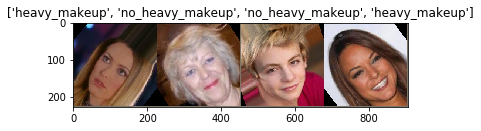

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
Now, let’s write a general function to train a model. Here, we will illustrate:

Scheduling the learning rate
Saving the best model
In the following, parameter scheduler is an LR scheduler object from torch.optim.lr_scheduler.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)                            
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

**Case 1:**
using ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

In [0]:
model_conv = models.alexnet(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier = nn.Sequential(*[model_conv.classifier[i] for i in range(6)]) # remove the last layer (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_conv.classifier = nn.Sequential(model_conv.classifier,addition_fc)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)

Let's train the model as a feature extractor

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.6419 Acc: 0.7090
val Loss: 2.0678 Acc: 0.7775

Epoch 1/24
----------
train Loss: 1.9588 Acc: 0.7375
val Loss: 1.4659 Acc: 0.8050

Epoch 2/24
----------
train Loss: 2.1547 Acc: 0.7500
val Loss: 2.6187 Acc: 0.7950

Epoch 3/24
----------
train Loss: 1.8378 Acc: 0.7680
val Loss: 1.1140 Acc: 0.7925

Epoch 4/24
----------
train Loss: 1.6932 Acc: 0.7615
val Loss: 2.4418 Acc: 0.7775

Epoch 5/24
----------
train Loss: 1.3737 Acc: 0.7985
val Loss: 1.2439 Acc: 0.7875

Epoch 6/24
----------
train Loss: 1.0989 Acc: 0.8100
val Loss: 0.8641 Acc: 0.7900

Epoch 7/24
----------
train Loss: 0.8710 Acc: 0.8110
val Loss: 0.9854 Acc: 0.7900

Epoch 8/24
----------
train Loss: 0.9041 Acc: 0.8105
val Loss: 0.8998 Acc: 0.7900

Epoch 9/24
----------
train Loss: 0.8545 Acc: 0.8025
val Loss: 0.8296 Acc: 0.7950

Epoch 10/24
----------
train Loss: 0.7957 Acc: 0.8265
val Loss: 0.8516 Acc: 0.7950

Epoch 11/24
----------
train Loss: 0.8073 Acc: 0.8095
val Loss: 0.8400 Acc: 0.7900

Ep

**Case 2**: Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

In [9]:
## Alexnet
model_ft = models.alexnet(pretrained=True)
model_ft.classifier = nn.Sequential(*[model_ft.classifier[i] for i in range(6)])  # remove the last layer (4096x1000)
addition_fc = nn.Linear(4096, 2) # the layer to be stacked
model_ft.classifier = nn.Sequential(model_ft.classifier,addition_fc)
#model_ft = nn.Sequential(model_ft,addition_fc)
print(model_ft)
##

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=9216, out_fe

Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than 5 minutes.

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6296 Acc: 0.6735
val Loss: 0.5207 Acc: 0.7275

Epoch 1/24
----------
train Loss: 0.4781 Acc: 0.7825
val Loss: 0.3508 Acc: 0.8625

Epoch 2/24
----------
train Loss: 0.3939 Acc: 0.8325
val Loss: 0.3521 Acc: 0.8675

Epoch 3/24
----------
train Loss: 0.3387 Acc: 0.8660
val Loss: 0.3302 Acc: 0.8625

Epoch 4/24
----------
train Loss: 0.2972 Acc: 0.8785
val Loss: 0.3929 Acc: 0.8275

Epoch 5/24
----------
train Loss: 0.2468 Acc: 0.8965
val Loss: 0.2788 Acc: 0.8975

Epoch 6/24
----------
train Loss: 0.2221 Acc: 0.9150
val Loss: 0.2895 Acc: 0.8875

Epoch 7/24
----------
train Loss: 0.2118 Acc: 0.9150
val Loss: 0.2658 Acc: 0.8975

Epoch 8/24
----------
train Loss: 0.2078 Acc: 0.9195
val Loss: 0.2674 Acc: 0.8900

Epoch 9/24
----------
train Loss: 0.1954 Acc: 0.9210
val Loss: 0.2654 Acc: 0.8925

Epoch 10/24
----------
train Loss: 0.1988 Acc: 0.9200
val Loss: 0.2760 Acc: 0.8925

Epoch 11/24
----------
train Loss: 0.1943 Acc: 0.9210
val Loss: 0.2734 Acc: 0.8875

Ep

**Visualizing the model predictions:**
Generic function to display predictions for a few images

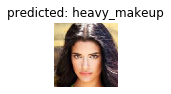

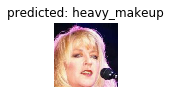

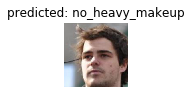

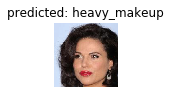

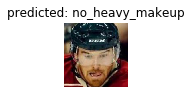

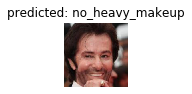

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
#model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
visualize_model(model_ft)

In [12]:
## Alexnet from scratch
model_fs = models.alexnet()
model_fs.classifier = nn.Sequential(*[model_fs.classifier[i] for i in range(6)])  # remove the last layer (4096x1000)
addition_fs = nn.Linear(4096, 2) # the layer to be stacked
model_fs.classifier = nn.Sequential(model_fs.classifier,addition_fs)
#model_ft = nn.Sequential(model_ft,addition_fc)
print(model_fs)
##

model_fs = model_fs.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_fs = optim.SGD(model_fs.parameters(), lr=0.001, momentum=0.9)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fs, step_size=5, gamma=0.1)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=9216, out_fe

In [13]:
model_fs = train_model(model_fs, criterion, optimizer_fs, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6935 Acc: 0.4895
val Loss: 0.6922 Acc: 0.5000

Epoch 1/24
----------
train Loss: 0.6928 Acc: 0.4970
val Loss: 0.6884 Acc: 0.6325

Epoch 2/24
----------
train Loss: 0.6786 Acc: 0.5730
val Loss: 0.6678 Acc: 0.6200

Epoch 3/24
----------
train Loss: 0.6559 Acc: 0.6125
val Loss: 0.6117 Acc: 0.6625

Epoch 4/24
----------
train Loss: 0.6304 Acc: 0.6560
val Loss: 0.6328 Acc: 0.6500

Epoch 5/24
----------
train Loss: 0.6034 Acc: 0.6745
val Loss: 0.6032 Acc: 0.6750

Epoch 6/24
----------
train Loss: 0.5933 Acc: 0.6830
val Loss: 0.5828 Acc: 0.6750

Epoch 7/24
----------
train Loss: 0.5892 Acc: 0.6885
val Loss: 0.6023 Acc: 0.6700

Epoch 8/24
----------
train Loss: 0.5950 Acc: 0.6750
val Loss: 0.5856 Acc: 0.6775

Epoch 9/24
----------
train Loss: 0.5832 Acc: 0.6955
val Loss: 0.5560 Acc: 0.7075

Epoch 10/24
----------
train Loss: 0.5722 Acc: 0.7100
val Loss: 0.5689 Acc: 0.6975

Epoch 11/24
----------
train Loss: 0.5687 Acc: 0.7130
val Loss: 0.5761 Acc: 0.6950

Ep

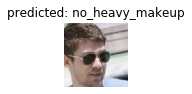

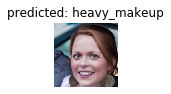

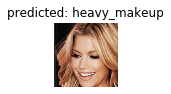

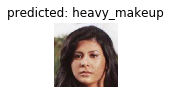

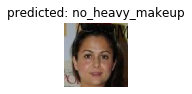

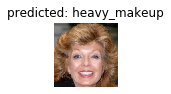

In [14]:
visualize_model(model_fs)

In [15]:
## VGG16
model_vgg = models.vgg16(pretrained=True)
model_vgg.classifier = nn.Sequential(*[model_vgg.classifier[i] for i in range(6)])  # remove the last layer (4096x1000)
addition_vgg = nn.Linear(4096, 2) # the layer to be stacked
model_vgg.classifier = nn.Sequential(model_vgg.classifier,addition_vgg)
#model_ft = nn.Sequential(model_ft,addition_fc)
print(model_vgg)
##

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_vgg = optim.SGD(model_vgg.parameters(), lr=0.001, momentum=0.9)

# step size could be
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vgg, step_size=5, gamma=0.1)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [16]:
model_vgg = train_model(model_vgg, criterion, optimizer_vgg, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4606 Acc: 0.7785
val Loss: 0.4415 Acc: 0.8250

Epoch 1/24
----------
train Loss: 0.3175 Acc: 0.8720
val Loss: 0.4773 Acc: 0.7975

Epoch 2/24
----------
train Loss: 0.2708 Acc: 0.8945
val Loss: 0.2539 Acc: 0.8975

Epoch 3/24
----------
train Loss: 0.2639 Acc: 0.8955
val Loss: 0.3038 Acc: 0.8725

Epoch 4/24
----------
train Loss: 0.2415 Acc: 0.8990
val Loss: 0.2365 Acc: 0.9000

Epoch 5/24
----------
train Loss: 0.1657 Acc: 0.9320
val Loss: 0.2547 Acc: 0.9050

Epoch 6/24
----------
train Loss: 0.1599 Acc: 0.9340
val Loss: 0.2448 Acc: 0.9150

Epoch 7/24
----------
train Loss: 0.1474 Acc: 0.9380
val Loss: 0.2411 Acc: 0.9075

Epoch 8/24
----------
train Loss: 0.1259 Acc: 0.9515
val Loss: 0.2924 Acc: 0.9000

Epoch 9/24
----------
train Loss: 0.1307 Acc: 0.9470
val Loss: 0.2600 Acc: 0.9075

Epoch 10/24
----------
train Loss: 0.1210 Acc: 0.9510
val Loss: 0.2642 Acc: 0.9050

Epoch 11/24
----------
train Loss: 0.1167 Acc: 0.9520
val Loss: 0.2641 Acc: 0.9025

Ep

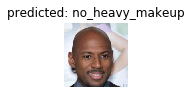

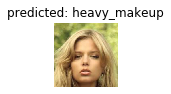

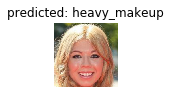

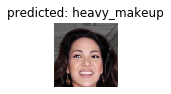

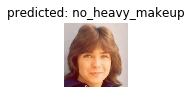

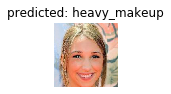

In [17]:
visualize_model(model_vgg)